In [1]:
%matplotlib inline
import os
os.chdir('d:/future/Index_Future_Prediction')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tqdm
import optuna
import math
from datetime import datetime
import backtrader as bt


import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.optim import lr_scheduler, Adam, AdamW
from torch.utils.data import TensorDataset, DataLoader

from utils import *
from modules import *

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

In [2]:
class Patch_TST(nn.Module):
    """Patch Time Series Transformer"""
    def __init__(self, input_size, seq_len, patch_size, stride, num_layer, num_head, d_model, masking_ratio, mask_expand_size, dropout_1, dropout_2, dropout_3):
        super().__init__()
        # parameters 
        self.device = 'cuda:0'
        self.input_size = input_size
        self.patch_size = patch_size
        self.stride = stride
        self.masking_ratio = masking_ratio
        self.mask_expand_size = mask_expand_size
        self.num_patch = int(np.floor((seq_len - patch_size) / stride) + 1)

        # modules
        self.patch = TimeSeriesPatcher(patch_size, stride) # 首先经过patcher分成子序列
        self.projection = PatchProjection(input_size, patch_size, d_model = d_model, dropout = dropout_1)
        self.encoder = MultiLayerEncoder(dim_feature = d_model, dim_sequence = self.num_patch, num_enc_layer = num_layer, num_head = num_head, num_ffn_hidden = d_model*2, dropout = dropout_2)
        self.reconstruction = nn.Linear(d_model, input_size * patch_size)
        self.output = nn.Sequential(
            nn.Flatten(start_dim = -2),
            nn.Linear(self.num_patch * d_model, self.num_patch * d_model),
            nn.ReLU(),
            nn.Dropout(dropout_3),
            HybridDecoder(dim_state = self.num_patch * d_model, init_prob = [0.0,0.0,0.0])
        )
    
    def self_supervised(self, x):
        """
        自监督预训练
        如果不允许patch重叠，正好被patch隔断的形态无法学习到。
        允许patch重叠，则模型预训练的时候可以从前后patch偷看到信息。
        需要用双重mask
        target mask 是真正需要重建的patch
        input mask 是target mask的扩展，根据系数向两侧扩展掩蔽范围。例如假如patch允许重叠50%，则向前后各多屏蔽一个patch就可以完全屏蔽掉信息。
        """
        device = x.device
        batch_size = x.shape[0]
        noise = torch.rand(size=(batch_size, self.num_patch), device=device)
        target_mask = noise < self.masking_ratio
        
        # 防止出现所有 patch 都没被 mask 的情况，至少 mask 一个随机选择一个 patch 进行 mask
        if not target_mask.any(dim=1).all():
            for i in range(batch_size):
                if not target_mask[i].any():
                    fallback_idx = torch.randint(0, self.num_patch, (1,)).item()
                    target_mask[i, fallback_idx] = True

        target_mask_float = target_mask.float().unsqueeze(1)
        kernel_size = 2 * self.mask_expand_size + 1
        kernel = torch.ones(1, 1, kernel_size, device=device)
        padding = self.mask_expand_size
        expanded_mask_float = F.conv1d(target_mask_float, kernel, padding=padding)
        input_mask = (expanded_mask_float > 0).squeeze(1)


        x_patched = self.patch(x)
        reshape_mask = input_mask.unsqueeze(-1)
        x_masked = torch.where(reshape_mask, 0.0, x_patched)
        x_projected = self.projection(x_masked)
        x_encodered = self.encoder(x_projected)
        
        x_pre_reconstruction = x_encodered[target_mask] # 仅关注target mask
        x_reconstructed = self.reconstruction(x_pre_reconstruction)
        x_target = x_patched[target_mask] # 仅关注target mask

        return x_reconstructed, x_target
    
    def forward(self, x):
        """前向传播输出"""
        x_patched = self.patch(x)
        x_projected = self.projection(x_patched)
        x_encodered = self.encoder(x_projected)
        output = self.output(x_encodered)
        return output

# 这些参数是两阶段共享的
params = {'seq_len': 182, 'patch_size': 16, 'num_layer': 5, 'num_head': 16, 'd_model': 64, 'batch_size': 32, 'dropout_1': 0.20327196251790136, 'dropout_2': 0.47008841920675076, 'dropout_3': 0.30232344273196965, 'learning_rate_encoder': 7.65587014578536e-05, 'weight_decay_encoder': 5.0407407354530355e-06, 'learning_rate_output': 0.007592481924799051, 'weight_decay_output': 4.198803479763781e-06, 'gamma': 0.7191406703312052, 'mask_expand_size': 3}

In [3]:
# 这些参数是两阶段共享的

seq_len = 180
patch_size = 16
num_layer = 5
num_head = 16
d_model = 64
stride = 4
masking_ratio = 0.2
mask_expand_size = 3

batch_size = 32

dropout_1 = 0.20327196251790136
dropout_2 = 0.47008841920675076
dropout_3 = 0.30232344273196965

learning_rate_encoder = 7.65587014578536e-05
weight_decay_encoder = 5.0407407354530355e-06

learning_rate_output = 0.007592481924799051
weight_decay_output = 4.198803479763781e-06

alpha = 0.02
delta = 1.2
gamma = 0.7191406703312052


In [4]:
# 提取数据
assets_list = ['IH.CFX', 'IF.CFX', 'IC.CFX', 'AU.SHF', 'JM.DCE','RB.SHF','HC.SHF', 'I.DCE', 'M.DCE', 'CF.ZCE',]

feature_columns = ['inday_chg_open','inday_chg_high','inday_chg_low','inday_chg_close','inday_chg_amplitude', 'ma_10','ma_26','ma_45','ma_90','ma_vol',]
label_columns = ['label_return','down_prob','middle_prob','up_prob']

feature = []
label = []
for asset_code in assets_list:
    data = pd.read_csv(f'data/{asset_code}.csv')
    data = data[data['trade_date'] < 20230901].copy() # 所有2023年以后数据不参与训练
    feature.append(torch.tensor(data[feature_columns].values, dtype = torch.float32, device = 'cuda:0'))
    label.append(torch.tensor(data[label_columns].values, dtype = torch.float32, device = 'cuda:0'))

feature = torch.stack(feature, dim = 1)
label = torch.stack(label, dim = 1)
feature = feature.unfold(dimension = 0, size = seq_len, step = 1).transpose(2,3)
label = label[seq_len-1:]
data = RandomLoader(feature, label)
train_loader, test_loader = data(batch_size=batch_size, slice_size=[0.8,0.19], balance=[True, True])

In [5]:
model = Patch_TST(input_size = 10,
                    seq_len = seq_len,
                    patch_size = patch_size,
                    stride = stride,
                    num_layer = num_layer, 
                    num_head = num_head,
                    d_model = d_model,
                    masking_ratio = masking_ratio,
                    mask_expand_size = mask_expand_size,
                    dropout_1 = dropout_1,
                    dropout_2 = dropout_2,
                    dropout_3 = dropout_3,
                    ).to('cuda:0')

optimizer = torch.optim.AdamW(model.parameters(), lr = learning_rate_encoder, weight_decay=weight_decay_encoder)
scheduler = lr_scheduler.StepLR(optimizer, step_size=1, gamma=gamma)

100%|██████████| 30/30 [04:47<00:00,  9.58s/it]


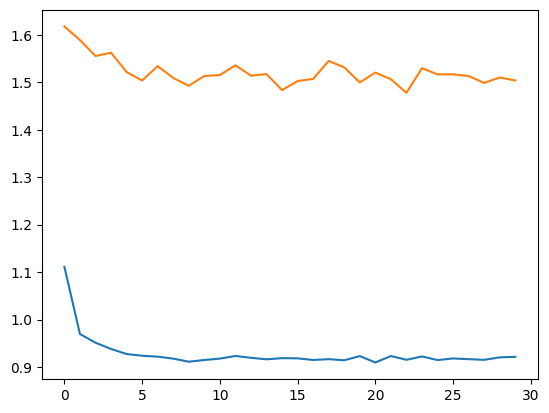

np.float64(1.5093467279997739)

In [6]:
loss_fn = nn.MSELoss()

def epoch():
    train_losses = []
    model.train()
    for batch_x, batch_y in train_loader:
        optimizer.zero_grad()
        x_reconstructed, x_target = model.self_supervised(batch_x)
        loss = loss_fn(x_reconstructed, x_target)
        train_losses.append(loss.item()) 
        loss.backward()
        optimizer.step()
        
    test_losses = []
    model.eval()
    with torch.no_grad():
        for batch_x, batch_y in test_loader:
            x_reconstructed, x_target = model.self_supervised(batch_x)
            loss = loss_fn(x_reconstructed, x_target)
            test_losses.append(loss.item()) 
    return np.mean(train_losses), np.mean(test_losses)

def pre_train(epochs = 30):
    train_losses = []
    test_losses = []
    for i in tqdm.tqdm(range(epochs)):
        train_loss, test_loss = epoch()
        train_losses.append(train_loss)
        test_losses.append(test_loss)
        scheduler.step()
    plt.plot(range(epochs), train_losses)
    plt.plot(range(epochs), test_losses)
    plt.show()
    return np.mean(test_losses[-10:])

pre_train(30)

In [7]:
# 提取部分数据用于二阶段训练
assets_list = ['IH.CFX', 'IF.CFX', 'IC.CFX', 'AU.SHF', 'JM.DCE','RB.SHF','HC.SHF', 'I.DCE', 'M.DCE', 'CF.ZCE',]
# assets_list = ['IH.CFX', 'IF.CFX', 'IC.CFX']
# assets_list = ['JM.DCE','RB.SHF','HC.SHF', 'I.DCE']
# assets_list = ['I.DCE']

feature_columns = ['inday_chg_open','inday_chg_high','inday_chg_low','inday_chg_close','inday_chg_amplitude', 'ma_10','ma_26','ma_45','ma_90','ma_vol',]
label_columns = ['label_return','down_prob','middle_prob','up_prob']

feature = []
label = []
for asset_code in assets_list:
    data = pd.read_csv(f'data/{asset_code}.csv')
    data = data[data['trade_date'] < 20230901].copy() # 所有2023年以后数据不参与训练
    feature.append(torch.tensor(data[feature_columns].values, dtype = torch.float32, device = 'cuda:0'))
    label.append(torch.tensor(data[label_columns].values, dtype = torch.float32, device = 'cuda:0'))

feature = torch.stack(feature, dim = 1)
label = torch.stack(label, dim = 1)
feature = feature.unfold(dimension = 0, size = seq_len, step = 1).transpose(2,3)
label = label[seq_len-1:]
data = RandomLoader(feature, label)
train_loader, test_loader = data(batch_size=batch_size, slice_size=[0.8,0.19], balance=[True, True])


In [8]:
torch.save(model.state_dict(), 'params/temp.params')

In [ ]:
model.load_state_dict(torch.load('params/temp.params'))

loss_fn = HybridLoss(alpha = alpha, delta = delta, show_loss = False)

def epoch():
    train_losses = []
    model.train()
    model.projection.eval()
    model.encoder.eval()
    for batch_x, batch_y in train_loader:
        optimizer.zero_grad()
        pred = model(batch_x)
        loss = loss_fn(pred, batch_y)
        train_losses.append(loss.item()) 
        loss.backward()
        optimizer.step()
        
    test_losses = []
    model.eval()
    with torch.no_grad():
        for batch_x, batch_y in test_loader:
            pred = model(batch_x)
            loss = loss_fn(pred, batch_y)
            test_losses.append(loss.item()) 
    return np.mean(train_losses), np.mean(test_losses)

def train(epochs = 30):
    train_losses = []
    test_losses = []
    for i in tqdm.tqdm(range(epochs)):
        train_loss, test_loss = epoch()
        train_losses.append(train_loss)
        test_losses.append(test_loss)
        scheduler.step()
    plt.plot(range(epochs), train_losses)
    plt.plot(range(epochs), test_losses)
    plt.show()
    return np.mean(test_losses[-3:])

train(10)

 40%|████      | 4/10 [00:36<00:54,  9.11s/it]

In [ ]:
class TargetPositionStrategy(bt.Strategy):
    """
    基于回望期信号确定目标仓位，并进行调整。
    同时记录每日的总资产价值用于后续绘图。
    """
    params = (
        ('lookback', 5),
    )

    def __init__(self):
        self.log_dates = []
        self.log_values = []

    def log(self, txt, dt=None):
        dt = dt or self.datas[0].datetime.date(0)
        print(f'{dt.isoformat()} - {txt}')
        
    def next(self):
        self.log_dates.append(self.data.datetime.date(0))
        self.log_values.append(self.broker.getvalue())

        for d in self.datas:
            if len(d) < self.p.lookback:
                continue
            signals = d.openinterest.get(size=self.p.lookback)
            target_position = int(sum(signals))
            current_position = self.getposition(d).size

            if target_position != current_position:
                self.order_target_size(data=d, target=target_position)
    
    def stop(self):

        for d in self.datas:
            if self.getposition(d).size != 0:
                self.order_target_size(data=d, target=0)

In [ ]:
start_date, end_date  = datetime(2021, 9, 1), datetime(2023, 9, 1)
cerebro = bt.Cerebro()


for asset_code in assets_list:
    data = pd.read_csv(f'data/{asset_code}.csv')
    data['trade_date'] = pd.to_datetime(data['trade_date'], format = '%Y%m%d')
    data.index = data['trade_date']

    input = torch.tensor(data[feature_columns].values, dtype = torch.float32, device = 'cuda:0')
    input = input.unfold(dimension = 0, size = seq_len, step = 1).transpose(1,2)
    output = model(input).detach().cpu().numpy()
    prob_prediction = np.argmax(output[:,1:], axis = 1) - 1  # 转换为 -1, 0, +1 的方向表示

    days = data['trade_date'][seq_len-1:]
    position = pd.Series(index = days, data = prob_prediction, name = 'openinterest') # 为了方便，我们直接覆盖掉没使用的open interest
    data = data.join(position, how='left')

    data['volume'] = data['vol']
    data = data[['open', 'high', 'low', 'close', 'volume', 'openinterest']][seq_len-1:].copy()
    feed_data = bt.feeds.PandasData(dataname=data, fromdate=start_date, todate=end_date, name = asset_code)  # 加载数据
    cerebro.adddata(feed_data)


cerebro.broker.setcash(70000.0) # 5份IH 5份IF 5份IC 最大理论单边持仓约7w
cerebro.broker.setcommission(commission=0.0001)
cerebro.addstrategy(TargetPositionStrategy)
cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name='sharpe')
cerebro.addanalyzer(bt.analyzers.Returns, _name='returns')
cerebro.addanalyzer(bt.analyzers.DrawDown, _name='drawdown')
cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name='trades')
cerebro.addanalyzer(bt.analyzers.PyFolio, _name='pyfolio')
results = cerebro.run()
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

strategy_instance = results[0]

sharpe_analysis = strategy_instance.analyzers.sharpe.get_analysis()
returns_analysis = strategy_instance.analyzers.returns.get_analysis()
drawdown_analysis = strategy_instance.analyzers.drawdown.get_analysis()
trades_analysis = strategy_instance.analyzers.trades.get_analysis()

print(f"Sharpe Ratio: {sharpe_analysis.get('sharperatio', 'N/A'):.4f}")
print(f"Annualized Return: {returns_analysis.get('rnorm100', 'N/A'):.2f}%")
print(f"Max Drawdown: {drawdown_analysis.max.get('drawdown', 'N/A'):.2f}%")
if trades_analysis.total.total > 0:
    print(f"Total Trades: {trades_analysis.total.total}")
    print(f"Win Rate: {(trades_analysis.won.total / trades_analysis.total.total) * 100:.2f}%")
    print(f"Average PnL per Trade: {trades_analysis.pnl.net.average:.2f}")

Final Portfolio Value: 86463.06
Sharpe Ratio: 0.6259
Annualized Return: 11.57%
Max Drawdown: 9.31%
Total Trades: 49
Win Rate: 48.98%
Average PnL per Trade: 348.77


In [ ]:
start_date, end_date  = datetime(2023, 9, 1), datetime(2024, 9, 1)
cerebro = bt.Cerebro()


for asset_code in assets_list:
    data = pd.read_csv(f'data/{asset_code}.csv')
    data['trade_date'] = pd.to_datetime(data['trade_date'], format = '%Y%m%d')
    data.index = data['trade_date']

    input = torch.tensor(data[feature_columns].values, dtype = torch.float32, device = 'cuda:0')
    input = input.unfold(dimension = 0, size = seq_len, step = 1).transpose(1,2)
    output = model(input).detach().cpu().numpy()
    prob_prediction = np.argmax(output[:,1:], axis = 1) - 1  # 转换为 -1, 0, +1 的方向表示

    days = data['trade_date'][seq_len-1:]
    position = pd.Series(index = days, data = prob_prediction, name = 'openinterest') # 为了方便，我们直接覆盖掉没使用的open interest
    data = data.join(position, how='left')

    data['volume'] = data['vol']
    data = data[['open', 'high', 'low', 'close', 'volume', 'openinterest']][seq_len-1:].copy()
    feed_data = bt.feeds.PandasData(dataname=data, fromdate=start_date, todate=end_date, name = asset_code)  # 加载数据
    cerebro.adddata(feed_data)


cerebro.broker.setcash(70000.0) # 5份IH 5份IF 5份IC 最大理论单边持仓约7w
cerebro.broker.setcommission(commission=0.0001)
cerebro.addstrategy(TargetPositionStrategy)
cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name='sharpe')
cerebro.addanalyzer(bt.analyzers.Returns, _name='returns')
cerebro.addanalyzer(bt.analyzers.DrawDown, _name='drawdown')
cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name='trades')
cerebro.addanalyzer(bt.analyzers.PyFolio, _name='pyfolio')
results = cerebro.run()
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

strategy_instance = results[0]

sharpe_analysis = strategy_instance.analyzers.sharpe.get_analysis()
returns_analysis = strategy_instance.analyzers.returns.get_analysis()
drawdown_analysis = strategy_instance.analyzers.drawdown.get_analysis()
trades_analysis = strategy_instance.analyzers.trades.get_analysis()

print(f"Sharpe Ratio: {sharpe_analysis.get('sharperatio', 'N/A'):.4f}")
print(f"Annualized Return: {returns_analysis.get('rnorm100', 'N/A'):.2f}%")
print(f"Max Drawdown: {drawdown_analysis.max.get('drawdown', 'N/A'):.2f}%")
if trades_analysis.total.total > 0:
    print(f"Total Trades: {trades_analysis.total.total}")
    print(f"Win Rate: {(trades_analysis.won.total / trades_analysis.total.total) * 100:.2f}%")
    print(f"Average PnL per Trade: {trades_analysis.pnl.net.average:.2f}")

Final Portfolio Value: 69781.51
Sharpe Ratio: -0.4200
Annualized Return: -0.32%
Max Drawdown: 8.61%
Total Trades: 29
Win Rate: 48.28%
Average PnL per Trade: -65.84


In [ ]:
start_date, end_date  = datetime(2024, 9, 1), datetime(2025, 9, 1)
cerebro = bt.Cerebro()


for asset_code in assets_list:
    data = pd.read_csv(f'data/{asset_code}.csv')
    data['trade_date'] = pd.to_datetime(data['trade_date'], format = '%Y%m%d')
    data.index = data['trade_date']

    input = torch.tensor(data[feature_columns].values, dtype = torch.float32, device = 'cuda:0')
    input = input.unfold(dimension = 0, size = seq_len, step = 1).transpose(1,2)
    output = model(input).detach().cpu().numpy()
    prob_prediction = np.argmax(output[:,1:], axis = 1) - 1  # 转换为 -1, 0, +1 的方向表示

    days = data['trade_date'][seq_len-1:]
    position = pd.Series(index = days, data = prob_prediction, name = 'openinterest') # 为了方便，我们直接覆盖掉没使用的open interest
    data = data.join(position, how='left')

    data['volume'] = data['vol']
    data = data[['open', 'high', 'low', 'close', 'volume', 'openinterest']][seq_len-1:].copy()
    feed_data = bt.feeds.PandasData(dataname=data, fromdate=start_date, todate=end_date, name = asset_code)  # 加载数据
    cerebro.adddata(feed_data)


cerebro.broker.setcash(70000.0) # 5份IH 5份IF 5份IC 最大理论单边持仓约7w
cerebro.broker.setcommission(commission=0.0001)
cerebro.addstrategy(TargetPositionStrategy)
cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name='sharpe')
cerebro.addanalyzer(bt.analyzers.Returns, _name='returns')
cerebro.addanalyzer(bt.analyzers.DrawDown, _name='drawdown')
cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name='trades')
cerebro.addanalyzer(bt.analyzers.PyFolio, _name='pyfolio')
results = cerebro.run()
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

strategy_instance = results[0]

sharpe_analysis = strategy_instance.analyzers.sharpe.get_analysis()
returns_analysis = strategy_instance.analyzers.returns.get_analysis()
drawdown_analysis = strategy_instance.analyzers.drawdown.get_analysis()
trades_analysis = strategy_instance.analyzers.trades.get_analysis()

print(f"Sharpe Ratio: {sharpe_analysis.get('sharperatio', 'N/A'):.4f}")
print(f"Annualized Return: {returns_analysis.get('rnorm100', 'N/A'):.2f}%")
print(f"Max Drawdown: {drawdown_analysis.max.get('drawdown', 'N/A'):.2f}%")
if trades_analysis.total.total > 0:
    print(f"Total Trades: {trades_analysis.total.total}")
    print(f"Win Rate: {(trades_analysis.won.total / trades_analysis.total.total) * 100:.2f}%")
    print(f"Average PnL per Trade: {trades_analysis.pnl.net.average:.2f}")

Final Portfolio Value: 67363.76
Sharpe Ratio: -1.4215
Annualized Return: -3.92%
Max Drawdown: 8.27%
Total Trades: 18
Win Rate: 16.67%
Average PnL per Trade: -282.47
